# Import Libraries

In [75]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from IPython import display
from PIL import Image
from torchvision import transforms, models

In [76]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Load Data

In [77]:
transform = transforms.Compose([
    transforms.Resize((298, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)
    )
])

In [78]:
def load_image(image_path, title):
    image = Image.open(image_path)
    plt.imshow(image)
  
    image = transform(image).unsqueeze(0)
    return image.to(device)

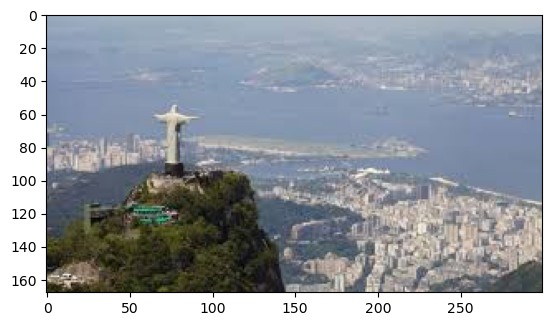

In [79]:
content_image_path = r"Wonders of World\Wonders of World\christ_the_reedemer\00b9b0a3ca.jpg"
content_image = load_image(content_image_path, "Content Image")

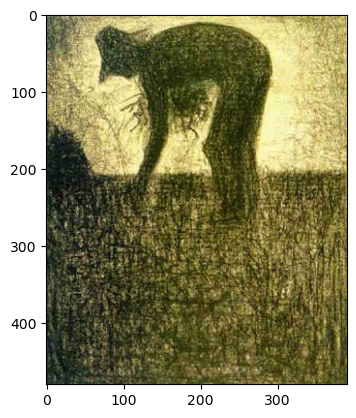

In [80]:
style_image_path = r"images\images\Georges_Seurat\Georges_Seurat_41.jpg"
style_image = load_image(style_image_path, "Style Image")

# Model

In [81]:
def get_features(x, model, layers):
    features = {}
    for name, layer in enumerate(model.children()):
        x = layer(x)
        if str(name) in layers:
            features[layers[str(name)]] = x
    return features

In [82]:
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

In [83]:
vgg = models.vgg19(weights=True).features.to(device).eval()

In [84]:
feature_layers = {}
layer_count = 0

for name, layer in vgg._modules.items():
    if isinstance(layer, torch.nn.Conv2d):
        layer_name = f'conv{layer_count//4 + 1}_{layer_count%4 + 1}'
        feature_layers[name] = layer_name
        layer_count += 1

content_layer = 'conv4_2'
num_style_layers = len(feature_layers) - 1
style_layers_dict = {layer: 1.0 / num_style_layers for layer in feature_layers.values()}

In [85]:
content_features = get_features(content_image, vgg, feature_layers)
style_features = get_features(style_image, vgg, feature_layers)

In [86]:
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

In [87]:
target = content_image.clone().requires_grad_(True).to(device)

# Train

In [88]:
style_weight = 1e6
content_weight = 1
optimizer = optim.Adam([target], lr=0.003)
steps = 450

In [89]:
style_losses = []
content_losses = []

In [90]:
for epoch in range(steps + 1):
    optimizer.zero_grad()
    
    target_features = get_features(target, vgg, feature_layers)
    
    content_loss = F.mse_loss(target_features[content_layer], content_features[content_layer])
    content_losses.append(content_loss.item())
    
    style_loss = 0
    for layer in style_layers_dict:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        layer_style_loss = style_layers_dict[layer] * F.mse_loss(target_gram, style_gram)
        style_loss += layer_style_loss / (target_feature.shape[1] * target_feature.shape[2] * target_feature.shape[3])

    style_losses.append(style_loss.item())
    
    neural_loss = content_weight * content_loss + style_weight * style_loss
    neural_loss.backward(retain_graph=True)
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f'Epoch [{epoch}/{steps}], Content Loss: {content_loss.item():.2}, Style Loss {style_loss.item():.2}')

Epoch [0/450], Content Loss: 0.0, Style Loss 5.2e+01
Epoch [100/450], Content Loss: 0.92, Style Loss 1.6e+01
Epoch [200/450], Content Loss: 0.99, Style Loss 6.8
Epoch [300/450], Content Loss: 1.0, Style Loss 3.7
Epoch [400/450], Content Loss: 1.1, Style Loss 2.2


# Results

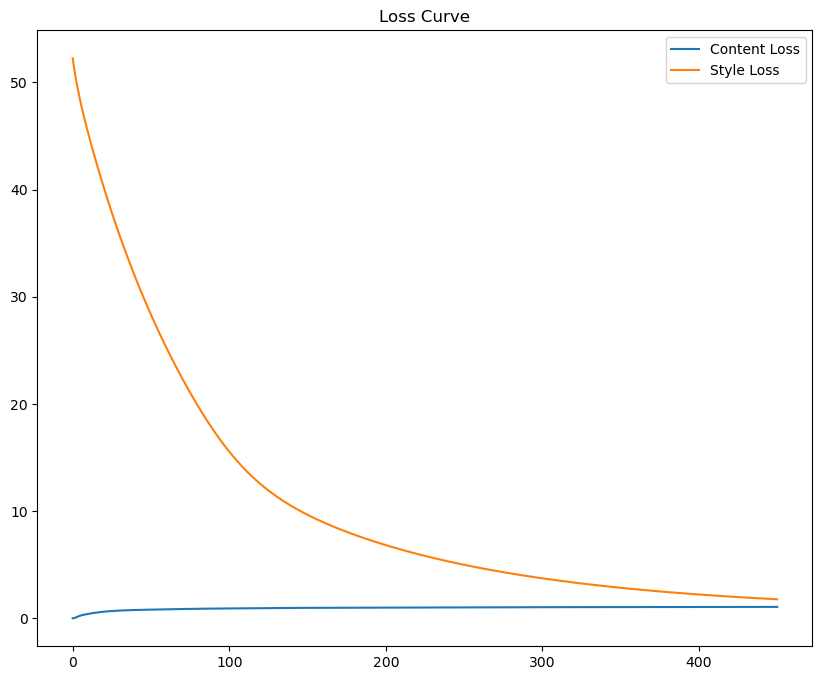

In [91]:
plt.figure(figsize=(10, 8))
plt.plot(content_losses)
plt.plot(style_losses)
plt.title("Loss Curve")
plt.legend(["Content Loss", "Style Loss"])
plt.show()

In [92]:
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * (0.229, 0.224, 0.225) + (0.485, 0.456, 0.406)
    image = image.clip(0, 1)
    return image

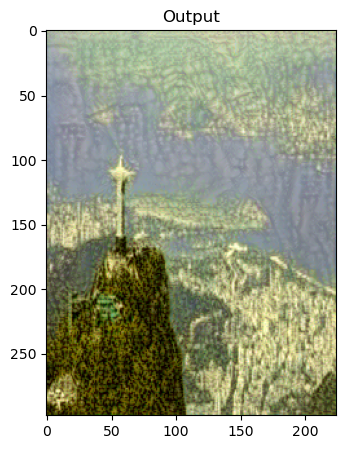

In [93]:
plt.figure(figsize=(10, 5))
plt.imshow(im_convert(target))
plt.title("Output")
plt.show()